# Поиск наиболее близких товаров.

### Постановка задачи.

Есть несколько файлов содержаших данные о товарах Винк.
Нужно построить модель , которая по введенным данным о товаре будет предсказывать наиболее близкий товар из ассортимента.
Для проверки модели предоставлен список соответствий составленных вручную. Метрика которая интересует заказчика - accuracy


Предоставленные данные
- Список товаров.csv (Основной файл с данными о   товарах)
- Товары с артикулом.csv
- Товары  с категорями.xls
- Сметченные позиции 1.csv
- Сметченные позиции 2.csv
- Сметченные позиции 3.csv

Описание полей.
 
 1) сметченные позиции
 - id,
 - "match_type", - тип сопоставления. Есть три типа сопоставления товаров: аналог, точное соответствие и нет сопоставления
 - "name",  - введенное название товара
 - "review_status", - это тип валидации. После сопоставления каждое сопоставление дополнительно проверяется, соответсвенно смотрим на статус
 - "validated" - значит метчинг проверили 2 раза и он сопоставлен. 
 - "sku_id", - id товара
 - "measurement_coefficient" -  коэффициент пересчета из базовой единицы измерения товара (уникальной для каждого SKU) в текущую единицу. Применяется для конвертации, например, рулонов в квадратные метры или в погонные метры.

2) Список товаров
 - sku_id, - id товара
 - "sku_name" - наименование товара 
 - "unit",  - единица измерения 
 - "net_weight_base_unit" - вес 
 - "length_base_unit", - длина
 - "width_base_unit", - ширина
 - "height_base_unit" - высота

### План работы

Первая часть работы будет посвещена загрузке и обработке данных.
Поскольку дано много файлов данных с разными полями, будем последовательно загружать, изучать их приводя к одинаковому формату. Одновременно с этим будет удалять дубликаты и подозрительные записи. В итоге в конце главы получим 2 датафрейма.
- df_vink_items данные о товарах
- df_match данные о соответствиях между товарами для проверки модели.
  
Вторая часть работы посвещена созданию модели для предсказания и оценке ее точности.

В заключительной части делаются выводы и даеются рекомендации.

### Загрузка библиотек

In [340]:
import random
import re

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pymorphy3
from gensim.models import FastText
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# Загружаем словари WordNet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [341]:
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 100
DIR = 'D:\\Matching\\'

### Загрузка данных

Всего заказчиком предоставлено 4 файлов данных. Будем загружать последовательно и разбираться с содержимым.

#### Список товаров

Основной файл с данными о товарах.

In [ ]:
df_vink_items = pd.read_csv(DIR+"Список товаров.csv")

Опять оставляем только имя и единицы.

In [365]:
df_vink_items = df_vink_items.rename(columns={'sku_name':'name','unit':'units'})
df_vink_items = df_vink_items[['name','units']]

In [366]:
df_vink_items.pivot_table(index='units',values = 'name', aggfunc = 'count').T

units,Нечто,ШТ.,бухта,кг,кор,л,лист,м,м2,м3,пог. м,рул,упак,шт
name,10,19101,43,382,4,15,116,51,88,2,129,12442,346,19101


Нечто переведем в шт, ШТ. в шт , бухту в упаковку , кор в упаковку.

In [367]:
df_vink_items.loc[df_vink_items['units']=='кор','units'] = 'упак'
df_vink_items.loc[df_vink_items['units']=='бухта','units'] = 'упак'
df_vink_items.loc[df_vink_items['units']=='ШТ.','units'] = 'шт'
df_vink_items.loc[df_vink_items['units']=='Нечто','units'] = 'шт'
df_vink_items.pivot_table(index='units',values = 'name', aggfunc = 'count').T

units,кг,л,лист,м,м2,м3,пог. м,рул,упак,шт
name,382,15,116,51,88,2,129,12442,393,38212


Дубликаты смотрим и удаляем

In [368]:
df_vink_items.duplicated().sum()

19250

ШТ. и шт были полностью дублированы. Причину этого нужно исправить на стороне заказчика.

In [369]:
df_vink_items = df_vink_items.drop_duplicates()
df_vink_items.shape

(32584, 2)

Посмотрим короткие имена

In [ ]:
df_vink_items.loc[df_vink_items['name'].str.len()<10].shape[0]

Видим, что есть весьма общие наименования. Есть так же тест2, тест4, v, test, тест, ТЕСТ удалим их.

In [371]:
df_vink_items = df_vink_items.loc[~df_vink_items['name'].isin(['тест2', 'тест4', 'v', 'test', 'тест', 'ТЕСТ'])].dropna()
df_vink_items.shape

(32576, 2)

##### Вывод

Датафрейм с товарами очишен и готов к использованию.

#### Товары с артикулом

Проводим аналогичные операции.

In [ ]:
df_vink_items2 = pd.read_csv(DIR+"Товары с артикулом.csv")

In [373]:
df_vink_items2.shape

(32981, 8)

Количество записей не совпадает с df_vink_items проверим чего нехватает.

In [ ]:
df_vink_items_delta = df_vink_items2.loc[~df_vink_items2['item_name'].isin(df_vink_items['name'])]

Проверяем короткие имена.

In [ ]:
df_vink_items_delta.loc[df_vink_items_delta['item_name'].str.len()<15].shape[0]

Удалим тесты. И переименуем столбцы.

In [376]:
df_vink_items_delta = df_vink_items_delta[['item_name']]
df_vink_items_delta = df_vink_items_delta.rename(columns={'item_name':'name'})

In [377]:
df_vink_items_delta = df_vink_items_delta.loc[~df_vink_items_delta['name'].isin(['test','тест','тест2','тест4','v','ТЕСТ'])].dropna()

In [378]:
df_vink_items_delta.shape

(277, 1)

Файл Товары с артикулом не содержит информации об единицах. Принимаем решение остамить только `name`. Объеденяем df_vink_items с df_vink_items_delta и удалим дубликаты.

In [379]:
df_vink_items = pd.concat([df_vink_items[['name']],df_vink_items_delta]).drop_duplicates()
df_vink_items.shape

(32839, 1)

##### Вывод

Из файла Товары с артикулом были извлечены надостающие товары и добавлены в df_vink_items.  Из df_vink_items удалена информация об единицах измерения. 

#### Товары  с категорями

Третий файл с информацией о   товарах.

In [380]:
df_vink_items3 = pd.read_excel(DIR+"Товары  с категорями.xls")

In [382]:
df_vink_items_delta2 = df_vink_items3.loc[~df_vink_items3['Номенклатура'].isin(df_vink_items['name'])]
df_vink_items_delta2.shape

(102, 21)

Поступаем как с предыдущим файлом и добавляем к df_vink_items

In [383]:
df_vink_items_delta2 = df_vink_items_delta2[['Номенклатура']]
df_vink_items_delta2 = df_vink_items_delta2.rename(columns={'Номенклатура':'name'})

In [384]:
df_vink_items_delta2.loc[df_vink_items_delta2['name'].str.len()<10]

,name


In [385]:
df_vink_items = pd.concat([df_vink_items[['name']],df_vink_items_delta2]).drop_duplicates().dropna()
df_vink_items.shape

(32940, 1)

##### Вывод

Извлекли недостающие наименования из Товары с категорями и добавили к df_vink_items.

#### Сметченные позиции 1

In [386]:
df_match = pd.read_csv(DIR+"Сметченные позиции 1.csv")

Оставим только проверенные точные соответствия. Просмотренные аналоги были очень далеки друг от друга по этому аналоги не рассматриваем.

In [388]:
df_match = df_match.loc[(df_match['review_status']=='validated')&(df_match['match_type']=='exact')]
df_match.shape

(12, 6)

Переименовываем столбцы.

In [ ]:
df_match = df_match[['name', 'sku_name']].drop_duplicates().rename(columns={'sku_name':'target'})

Удаляем первую тестовую запись .

In [ ]:
df_match = df_match.drop(labels = [0,3],axis = 0)

In [393]:
df_match.shape

(10, 2)

##### Вывод 

Очистили файл Сметченные позиции 1, всего осталось 10 достоверных соответствий. 

#### Сметченные позиции 2

Второй файл со сметченными позициями. Аналогично оставляем только достоверные соответствия. 

In [394]:
df_match2 = pd.read_csv(DIR+"Сметченные позиции 2.csv")
df_match2.shape

(315, 6)

In [395]:
df_match2 = df_match2.loc[(df_match2['match_status']=='validated')&(df_match2['match_type']=='exact')]
df_match2.shape

(74, 6)

Извлекаем названия, объеденяя таблицы

In [ ]:
df_match2 = df_match2[['product_name', 'sku_name']].drop_duplicates().rename(columns={'sku_name':'target','product_name':'name'})

In [399]:
df_match2 = df_match2.drop(labels = [0,1],axis = 0)

In [400]:
df_match2.shape

(68, 2)

Добавляем полученные записи к df_match

In [401]:
df_match = pd.concat([df_match,df_match2])
df_match.shape

(78, 2)

In [402]:
df_match['name'].duplicated().sum()

0

##### Вывод

Очистили файл Сметченные позиции 2, и добавили данные к df_match.

#### Сметченные позиции 3

Проводим аналогичные шаги.

In [427]:
df_match3 = pd.read_csv("D:\Matching\Сметченные позиции 3.csv")
df_match3.shape

(597, 12)

In [405]:
df_match3 = df_match3.loc[(df_match3['review_status']=='validated')&(df_match3['match_type']=='exact')]
df_match3.shape

(219, 12)

Переименовываем и убираем ошибочные записи.

In [406]:
df_match3 = df_match3[['name','item_name']].rename(columns={'item_name':'target'})

In [407]:
df_match3 = df_match3.drop(labels=[2,8],axis=0)

In [408]:
df_match = pd.concat([df_match,df_match3])
df_match.shape

(295, 2)

Дубликаты удаляем.

In [409]:
df_match.duplicated().sum()

29

In [410]:
df_match = df_match.drop_duplicates()
df_match.shape

(266, 2)

##### Вывод

Добависли данные из Сметченные позиции 3 в df_match

#### Вывод

После загрузки и первичной обработки есть 2 датафрейма
- df_vink_items список товаров
- df_match список проверенных соответствий между товарами (target) и вводимыми данными (name)


Можно сделать рекомендацию:
- В описании   товаров делать более информативные названия. Сейчас, например, присктствуют такие товары как "Картины" , "Cверло" и т.д.

### Модель

#### Формулировка и обучение модели.

После загрузки данных задача стала более конкретной. Есть датафрейм со строками - названиями   товаров. Для вводимой строки названия товара нужно находить максимально близкую строку названия товара из ассортимента.
Поскольку порядок слов и чисел в названиях не очень существеннен, то будем использовать TF-IDF векторизацию. 
Поскольку в названии могут быть слова , числа , различные символы, разделители десятичной части. 
То оставляем только слова и числа, приводим буквы к нижнему регистру. 

Простой токенизатор разбиение на слова и числа.

In [419]:
def extract_tokens(text):
    # Регулярное выражение находит числа (с точкой или запятой) и слова (русские и латинские)
    tokens = re.findall(r'\d+(?:[.,]\d+)?|[A-Za-zА-Яа-я]+', text)
    result = []
    for token in tokens:
        # Если токен начинается с цифры, считаем его числом и сохраняем как есть
        if re.match(r'^\d', token):
            result.append(token)
        else:
            # Для слов приводим к нижнему регистру и оставляем, если длина больше 3 символов
            token_lower = token.lower()
            if len(token_lower) > 1:
                result.append(token_lower)
    return result

# Кастомный токенайзер для TfidfVectorizer
def custom_tokenizer(text):
    return extract_tokens(text)

Более сложный токенизатор показывает лучшую метрику.
Каждый текст соответстующий товару преобразуется следующим образом. 
- Остаются только буквы, цифры и точка/запятая , если они между цифр.
- Удаляются числа начинающиеся с 0  (Иначе это не число, например, 0123)
- Удаляются числа после которых идут кг (этих величин часто нет)
- Удаляются слова короче 3 букв кроме отдельностоящих заглавных латинских букв. (Такие буквы часто имеет смысл обозначения модификации)
- Все буквы приводятся к строчным.

In [420]:
def extract_tokens(text):
    """
    Функция извлекает:
      - Числа (целые и дробные, разделитель может быть точкой или запятой),
        при этом:
          * Отбрасываются числа, начинающиеся с 0.
          * Отбрасываются числа, после которых через пробел идёт 'кг'.
      - Слова (русские и латинские, если их длина > 3 символов, приводятся к нижнему регистру).
      - Отдельностоящие заглавные латинские буквы.
    """
    # Регулярное выражение:
    # (?!0\d)                - число не должно начинаться с 0 (например, 0123 не подходит)
    # \d+(?:[.,]\d+)?        - число с необязательной дробной частью
    # (?!\s+кг)              - сразу после числа не должно идти пробельное пространство и "кг"
    # [A-Za-zА-Яа-я]+        - последовательности букв (русские и латинские)
    # \b[A-Z]\b              - отдельностоящие заглавные латинские буквы
    pattern = pattern = r'(?!0\d)\d+(?:[.,]\d+)?(?!\s+кг)|[A-Za-zА-Яа-я]+|(?:\b[A-Z]\b|(?<=\d)[A-Z]|[A-Z](?=\d))'
    
    tokens = re.findall(pattern, text)
    result = []
    
    for token in tokens:
        # Если токен начинается с цифры – это число
        if re.match(r'^\d', token):
            result.append(token)
        # Если токен – это отдельная заглавная латинская буква, оставляем его без изменений
        elif re.match(r'^[A-Z]$', token):
            result.append(token)
        else:
            token_lower = token.lower()
            # Добавляем слово, если его длина больше 3 символов
            if len(token_lower) > 3:
                result.append(token_lower[:4])
    return result

# Кастомный токенайзер для TfidfVectorizer
def custom_tokenizer(text):
    return extract_tokens(text)

Используя токенизатор делаем TF-IDF векторизацию и обучаем модель ближайших соседей используя в качестве метрики косинусное сходство. Количество ближайших соседей N можно изменять. 
Затем смотрим на датасете df_match длю случаев, когда верный ответ находится среди N ближайших соседей.

In [421]:


# Построение TF‑IDF векторизатора на   товарах (df_vink_items)
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
tfidf_vink_items = vectorizer.fit_transform(df_vink_items['name'])

# Создаем модель NearestNeighbors для поиска ближайших товаров,
# используем косинусное расстояние (в sklearn метрика "cosine" возвращает расстояние)
N = 5  # Количество наиболее похожих товаров, которое мы будем выдавать для каждого запроса
nn_model = NearestNeighbors(metric='cosine')
nn_model.fit(tfidf_vink_items)

# Функция для получения топ-N   товаров для заданного вводимого названия товара,
# возвращает список кортежей (название, мера сходства), где мера = 1 - косинусное расстояние
def get_top_n_products(query_text, n=N):
    query_vector = vectorizer.transform([query_text])
    distances, indices = nn_model.kneighbors(query_vector,n)
    # Преобразуем расстояния в сходство: чем меньше расстояние, тем больше сходство
    similarities = 1 - distances[0]
    predicted_products = df_vink_items.iloc[indices[0]]["name"].tolist()
    # Формируем список кортежей (название, сходство)
    return list(zip(predicted_products, similarities))

# Оценка модели на тестовом датасете (df_match)
# Если правильный (target) товар попал в топ-N, считаем предсказание корректным.
correct = 0
n_total = df_match.shape[0]

for idx, row in df_match.iterrows():
    name = row['name']
    target = row['target']
    predictions = get_top_n_products(name, n=N)
    predicted_names = [p[0] for p in predictions]
    if target in predicted_names:
        correct += 1
    # Для наглядности можно вывести результаты:
    #print("Название:", name)
    #print("Топ предсказаний (название, сходство):")
    #for product, sim in predictions:
        #print(f"  {product}: {sim:.4f}")
    #print("Ожидаемый товар из ассортимента:", target)
    #print("---")

accuracy = correct / n_total
print("Accuracy модели:", accuracy)

Accuracy модели: 0.6578947368421053


Дальнейшее усложнение, например, добавление лемматизации и стемминга. К улучшкеию метрик не приводит. 

```
# Инициализируем лемматизатор и стеммеры
morph = pymorphy3.MorphAnalyzer()
rus_stemmer = SnowballStemmer("russian")
eng_stemmer = SnowballStemmer("english")
eng_lemmatizer = WordNetLemmatizer()

# Функция токенизации с выделением нужных паттернов
def extract_tokens(text):
    pattern = r'(?!0\d)\d+(?:[.,]\d+)?(?!\s+кг)|[A-Za-zА-Яа-я]+|(?:\b[A-Z]\b|(?<=\d)[A-Z]|[A-Z](?=\d))'
    tokens = re.findall(pattern, text)
    result = []
    for token in tokens:
        # Числа оставляем без изменений
        if re.match(r'^\d', token):
            result.append(token)
        else:
            result.append(token.lower())
    return result

# Новый токенайзер: токенизация + лемматизация + стемминг
def custom_tokenizer(text):
    raw_tokens = extract_tokens(text)
    processed = []
    for token in raw_tokens:
        # Если токен - число
        if re.match(r'^\d', token):
            processed.append(token)
        # Если есть кириллический символ, применяем pymorphy2 + русский стеммер
        elif re.search(r'[а-яё]', token):
            lemma = morph.parse(token)[0].normal_form
            stem = rus_stemmer.stem(lemma)
            processed.append(stem)
        # Иначе считаем латинским: применяем WordNetLemmatizer + английский стеммер
        else:
            lemma = eng_lemmatizer.lemmatize(token)
            stem = eng_stemmer.stem(lemma)
            processed.append(stem)
    return processed
```

#### Анализ точности предсказаний

Построим график зависимости accuracy от величины окна N.

Top-1: Accuracy = 25.56%
Top-2: Accuracy = 40.23%
Top-3: Accuracy = 48.87%
Top-4: Accuracy = 59.40%
Top-5: Accuracy = 65.79%
Top-6: Accuracy = 69.92%
Top-7: Accuracy = 72.93%
Top-8: Accuracy = 77.82%
Top-9: Accuracy = 80.83%
Top-10: Accuracy = 83.46%


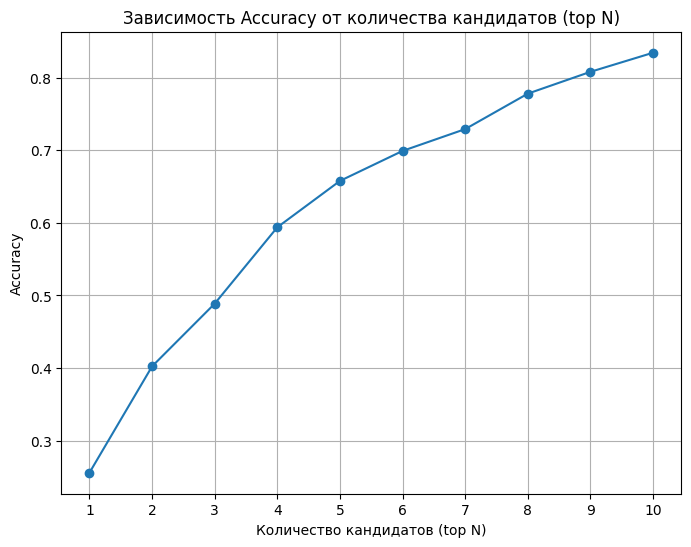

In [423]:
# Модель NearestNeighbors для поиска ближайших товаров с косинусной метрикой
top_candidates = 10  # максимальное количество кандидатов, которое будем получать для дальнейшей оценки
nn_model = NearestNeighbors(n_neighbors=top_candidates, metric='cosine')
nn_model.fit(tfidf_vink_items)

results = []  # список словарей с информацией для каждого запроса


for idx, row in df_match.iterrows():
    name = row['name']
    target = row['target']
    predictions = get_top_n_products(name, n=top_candidates)
    # Определим позицию, на которой находится target (если отсутствует, запишем None)
    positions = [i for i, (prod, sim) in enumerate(predictions, start=1) if prod == target]
    pos = positions[0] if positions else None
    results.append({'name': name, 'target': target, 'predictions': predictions, 'position': pos})
    
# Теперь вычислим accuracy для диапазона N от 1 до top_candidates.
top_n_values = range(1, top_candidates + 1)
accuracies = []

for n in top_n_values:
    correct = 0
    total = len(results)
    for res in results:
        # Если target находится на позиции <= n, то считаем корректным предсказанием.
        if res['position'] is not None and res['position'] <= n:
            correct += 1
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Top-{n}: Accuracy = {accuracy:.2%}")

# Строим график зависимости accuracy от top-N
plt.figure(figsize=(8, 6))
plt.plot(list(top_n_values), accuracies, marker='o', linestyle='-')
plt.xlabel('Количество кандидатов (top N)')
plt.ylabel('Accuracy')
plt.title('Зависимость Accuracy от количества кандидатов (top N)')
plt.grid(True)
plt.xticks(list(top_n_values))
plt.show()

Видно, что несмотря на низкую точность отдельного предсказания, точность быстро растет с ростом окна N.

Были опробованы и другие более сложные варианты токенизатора, рассмотрены отдельно числа и слова с разными весами, после поиска лучших вариантов моделью ближайших соседей добавлялся второй уровень с использованием библиотеки fasttext. Но метрика у всех этих вариантов была ниже чем у самого простого ванианта , приведенного выше.

Посмотрим теперь на распределение косинусного сходства по датасету df_match

In [424]:
def sims_graph(df):# Сбор значений сходства
    similarities = []
    for name in tqdm(df['name']):
        vec = vectorizer.transform([name])
        dists, _ = nn_model.kneighbors(vec, n_neighbors=1)
        sims = (1 - dists[0]).tolist()
        similarities.extend(sims)

    # Рисуем гистограмму распределения сходства
    plt.figure(figsize=(8, 6))
    plt.hist(similarities, bins=25)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Frequency')
    plt.title('Распределение косинусного сходства предсказаний')
    plt.grid(True)
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 266/266 [00:02<00:00, 111.34it/s]


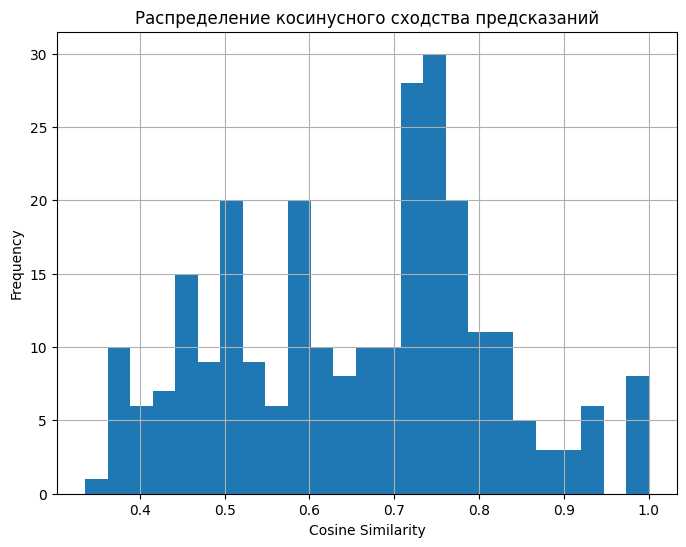

In [425]:
sims_graph(df_match)

### Вывод 

Для решения задачи поиска наиболее близких товаров были обработаны предоставленные файлы данных. Было принято решение анализировать только строку названия товара. Были объеденения данные из следующих групп файлов

- Список   товаров.csv
- Товары с артикулом.csv
- Товары с категорями.xls

и

- Сметченные позиции 1.csv
- Сметченные позиции 2.csv
- Сметченные позиции 3.csv

Затем была обучена модель для предсказания, которая состоит из TF-IDF векторизации и модели ближайших соседей работающей на этой векторизации с метрикой косинусного сходства.  
Метрика accuracy на тестовых данных составила 25.6% на одиночном предсказании и 65.8% на выборке из топ-5.

Для улучшения качества модели следующие рекомендации: увеличить датасет со сметченными товарами и повысить его достоверность, проверить полноту описаний товаров. 